In [34]:
import numpy as np
import pandas as pd
import time
import math
import itertools
import os
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/QA_results.zip

In [ ]:
def create_dir(path, log=False):
    if not os.path.exists(path):
        if log:
            print('The directory', path, 'does not exist and will be created')
        os.makedirs(path)
    else:
        if log:
            print('The directory', path, ' already exists')

In [ ]:
folder = os.path.join('QA_results', str(123), 'output')

### GCS-Q Quantum Annealer vs GCS-Q Classical 
### Plot runtimes up to 27 agents

In [ ]:
def collect_files(report_filename):

    IDP_brute_force = bool(int(report_filename.split('_')[-2][0]))
    IDP_topdown_min_cut = bool(int(report_filename.split('_')[-2][1]))
    IDP_min_cut_dwave_annealer = bool(int(report_filename.split('_')[-2][2]))

    report_file_obj = open(os.path.join(report_filename),'r')
    table_contents = [line.replace('\n','').split('__') for line in report_file_obj.readlines()]
    #view output table
    def highlight_false(s, column):
        is_false = pd.Series(data=False, index=s.index)
        is_false[column] = round(s.loc[column],2)<1.0
        return ['color: #ff8888' if is_false.any() else '' for v in is_false]

    base_cols = ['Distribution', 'No. of Agents']
    sub_cols = ['', '']

    if IDP_brute_force:
        base_cols = base_cols+['Brute Force']*3
        sub_cols=sub_cols+['Result', 'Value', 'TTE']
    if IDP_topdown_min_cut:
        base_cols = base_cols+['Top-down approach using min-cut']*4
        sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']
    if IDP_min_cut_dwave_annealer:
        base_cols = base_cols+['Dwave Annealer']*4
        sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']


    column_arrays = [base_cols, sub_cols]


    #df = pd.DataFrame(table_contents, columns=table_headers)
    df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))
    return df

In [ ]:
pd.set_option('display.max_rows', None)

report_filename = "IDP_report_011_123.txt"
df = collect_files(report_filename)

df.head()

Distribution No. of Agents Top-down approach using min-cut  \
                                                      Result   
0      laplace             2                         ['1,2']   
1      laplace             3                    ['3', '1,2']   
2      laplace             4               ['2,4', '3', '1']   
3      laplace             5                ['1,2,5', '3,4']   
4      laplace             6              ['1,3,6', '2,4,5']   

                                                          Dwave Annealer  \
                Value                    TTE Quality              Result   
0                 2.5                    0.0       1             ['1,2']   
1                 2.5                    0.0       1        ['1,2', '3']   
2                2.89                    0.0       1   ['1', '3', '2,4']   
3  21.639999999999997                    0.0       1    ['1,2,5', '3,4']   
4  21.099999999999998  0.0010342597961425781       1  ['2,4,5', '1,3,6']   

                                                  
                Value                TTE Quality  
0                 2.5                0.0     1.0  
1                 2.5  5.190215110778809     1.0  
2                2.89  10.37340497970581     1.0  
3  21.639999999999997  9.827338695526123     1.0  
4  21.099999999999998  14.80012822151184     1.0

laplace
normal


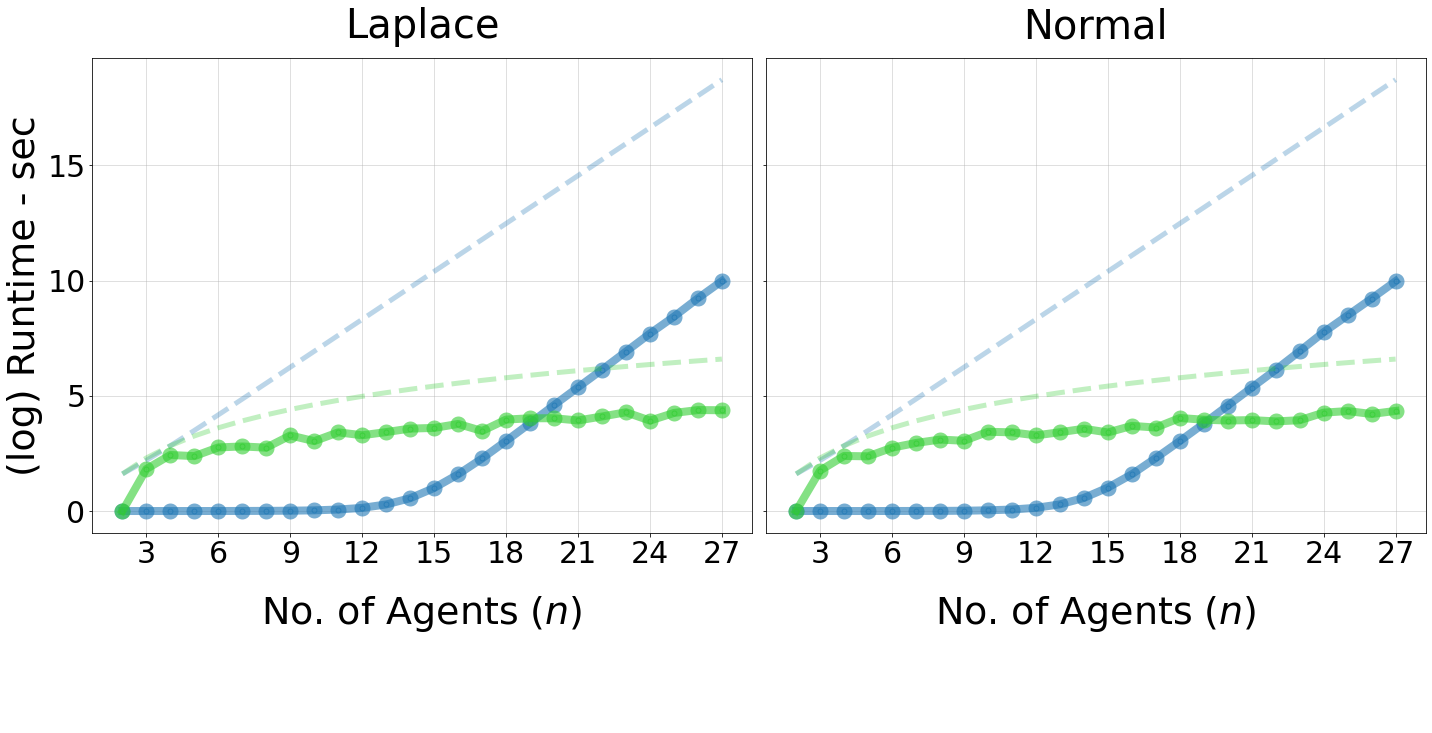

In [ ]:
folder = folder
out_folder= 'QA vs MIN-CUT'
df=df
log_scale=True
save=True
font=28
labels = [['Top-down approach using min-cut', 'GCS-Q Classical'], ['Dwave Annealer', 'GCS-Q Quantum Annealer']]


fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20,9))
fig.set_tight_layout(True)
ax[0].set_ylabel(r"(log) Runtime - sec", fontsize=font+10)
plt.setp(ax, xticks=np.arange(1, 31, 3))#), xticklabels=np.arange(2, 27, 3))


current_folder = os.path.join(folder, out_folder )
create_dir(current_folder)

i=0

for distr in df.Distribution.unique():
    if distr=="uniform":
        continue
    print(distr)
    data = df[df.Distribution == distr]

    n = np.array(list(map(int,data['No. of Agents'])))

    #ax[i].figure(figsize=(8,5))
    x = data['No. of Agents'].to_numpy()

    y_classical = data[(labels[0][0], 'TTE')].astype(float).to_numpy()
    y_classical_theoretical = (2)**(n)

    y_QA = data[(labels[1][0], 'TTE')].astype(float).to_numpy()
    y_QA_theoretical = (n)**(2)

    if log_scale:
        y_classical = np.log(y_classical+1)
        y_classical_theoretical = np.log(y_classical_theoretical+1)
        y_QA = np.log(y_QA+1)
        y_QA_theoretical = np.log(y_QA_theoretical+1)

        
    ax[i].plot(x, y_classical, label="GCS-Q$^{(c)}$", linestyle='-', marker='o', linewidth=8.0, markeredgewidth=10, alpha=.6, color='#1f77b4')
    ax[i].plot(x, y_classical_theoretical,  linestyle = 'dashed', linewidth=5.0, alpha =.3, color='#1f77b4', label="GCS-Q$^{(c)}/t$")
    #ax[i].plot(x, y_classical_theoretical,  linestyle = 'dotted', label="GCS-Q$^{(c)}$ ($\mathcal{O}(n2^n)$)", color='#1f77b4', linewidth=2.0)

    ax[i].plot(x, y_QA, label="GCS-Q$^{(q)}$", linestyle='-', marker='o', linewidth=8.0, markeredgewidth=10, alpha=.6, color='limegreen')
    ax[i].plot(x, y_QA_theoretical,  linestyle = 'dashed', color='limegreen', linewidth=5.0, alpha =.3, label="GCS-Q$^{(q)}/t$") # color='#ff7f0e'
    #ax[i].plot(x, y_QA_theoretical,  linestyle = 'dotted', label="GCS-Q$^{(q)}$ ($\mathcal{O}(n^2)$)", color='#ff7f0e', linewidth=2.0)

    ax[i].tick_params(axis="both", labelsize=font+2)

    ax[i].set_xlabel(r'No. of Agents $(n)$',fontdict={'fontsize':font+10}, labelpad=25)
    #plt.ylabel(r"(log scale) QA runtime - sec",fontdict={'fontsize':font+8})

    ax[i].grid(alpha=.5)
    ax[i].set_title(distr.title(), fontdict={'fontsize':font+12}, pad=20)#, fontweight="bold")
    i+=1
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', fontsize=font+8, ncol=4, bbox_to_anchor=(.53, .01))

#plt.legend(fontsize=font+8, ncol=2, bbox_to_anchor=(.3, -.4))
file = os.path.join(current_folder, 'runtime_q_vs_c.png')
if save:
    plt.savefig(file, dpi=300, bbox_inches = "tight")
plt.show()

## Plot the Quality for IDP(Brute Force) vs $GCS-Q^{(c)}$

In [ ]:
report_filename = "IDP_report_111_123.txt"
df = collect_files(report_filename)
df.head()

Distribution No. of Agents         Brute Force                      \
                                          Result               Value   
0      laplace             2             ['1,2']                 2.5   
1      laplace             3        ['3', '1,2']                 2.5   
2      laplace             4   ['2,4', '3', '1']                2.89   
3      laplace             5    ['1,2,5', '3,4']  21.639999999999997   
4      laplace             6  ['1,3,6', '2,4,5']  21.099999999999998   

                         Top-down approach using min-cut                      \
                     TTE                          Result               Value   
0  0.0009906291961669922                         ['1,2']                 2.5   
1                    0.0                    ['3', '1,2']                 2.5   
2                    0.0               ['2,4', '3', '1']                2.89   
3  0.0009961128234863281                ['1,2,5', '3,4']  21.639999999999997   
4   0.001994609832763672              ['1,3,6', '2,4,5']  21.099999999999998   

                                      Dwave Annealer                      \
                     TTE Quality              Result               Value   
0                    0.0     1.0             ['1,2']                 2.5   
1  0.0010154247283935547     1.0        ['3', '1,2']                 2.5   
2  0.0009951591491699219     1.0   ['1', '3', '2,4']                2.89   
3                    0.0     1.0    ['1,2,5', '3,4']  21.639999999999997   
4  0.0009975433349609375     1.0  ['1,3,6', '2,4,5']  21.099999999999998   

                               
                  TTE Quality  
0                 0.0     1.0  
1   5.409874200820923     1.0  
2   9.935318231582642     1.0  
3   10.16195011138916     1.0  
4  14.997750997543335     1.0

In [ ]:
current_folder = file = os.path.join(folder, 'Quality')
create_dir(current_folder)

In [ ]:
data = pd.concat([df["Distribution"] , df["No. of Agents"], df[('Top-down approach using min-cut', 'Quality')]], axis = 1)
data.columns = ["Distribution", "n", "Quality"]
data.Quality = data.Quality.astype(float)
data['Error'] = 1-data.Quality
data.head()

,Distribution,n,Quality,Error
0,laplace,2,1.0,0.0
1,laplace,3,1.0,0.0
2,laplace,4,1.0,0.0
3,laplace,5,1.0,0.0
4,laplace,6,1.0,0.0


C:\Users\anma10\PycharmProjects\DP-Q\venv\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
C:\Users\anma10\PycharmProjects\DP-Q\venv\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


Approximation of (Classical) GCS-Q


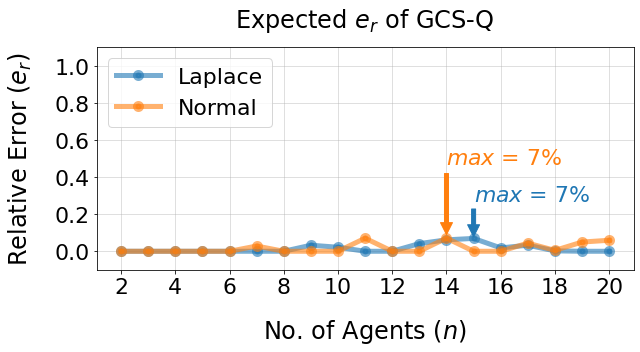

In [ ]:
font=16

fig, ax = plt.subplots(figsize=(9,5))
fig.set_tight_layout(True)

colors=['#1f77b4','#ff7f0e']
c = 0

for distr in df.Distribution.unique():
    if distr == "uniform":
        continue
    current_data = data[data.Distribution == distr]
    
    x = current_data['n'].to_numpy()

    y = current_data['Error'].astype(float).to_numpy()
    
    ax.plot(x, y, label=distr.capitalize(), linestyle='-', marker='o', linewidth=5.0, markeredgewidth=5, alpha=.6)

    ymax = max(y)
    xpos = np.where(y==ymax)
    xmax = x[xpos]

    ax.annotate("$max$ = "+f"{np.round(ymax*100).astype(int)}%", xy=(xmax, ymax), xytext=(xmax, ymax+0.4 if c else ymax+0.2), color= colors[c], fontsize=font+6,
                arrowprops=dict(color=colors[c], facecolor=colors[c], shrink=0.05))
    c+=1


ax.set_ylabel(r'Relative Error $(e_r)$',fontdict={'fontsize':font+8}, labelpad=20)

ax.set_xlabel(r'No. of Agents $(n)$',fontdict={'fontsize':font+8}, labelpad=20)
ax.set_ylim(-.1, 1.1)

ax.set_xticks(ticks=np.arange(0, 20, 2))
ax.set_yticks(ticks=np.arange(0, 1.1, .2))

ax.tick_params(axis='both', which='major', labelsize=font+6)

ax.grid(alpha=.5)
ax.legend(fontsize=font+6, loc="upper left")

ax.set_title(r"Expected $e_r$ of GCS-Q ", fontdict={'fontsize':font+8}, pad=20)#, fontweight="bold")

print("Approximation of (Classical) GCS-Q")

file = os.path.join(current_folder, 'MINCUT_Acc.png')
plt.savefig(file, dpi=500, bbox_inches = "tight")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


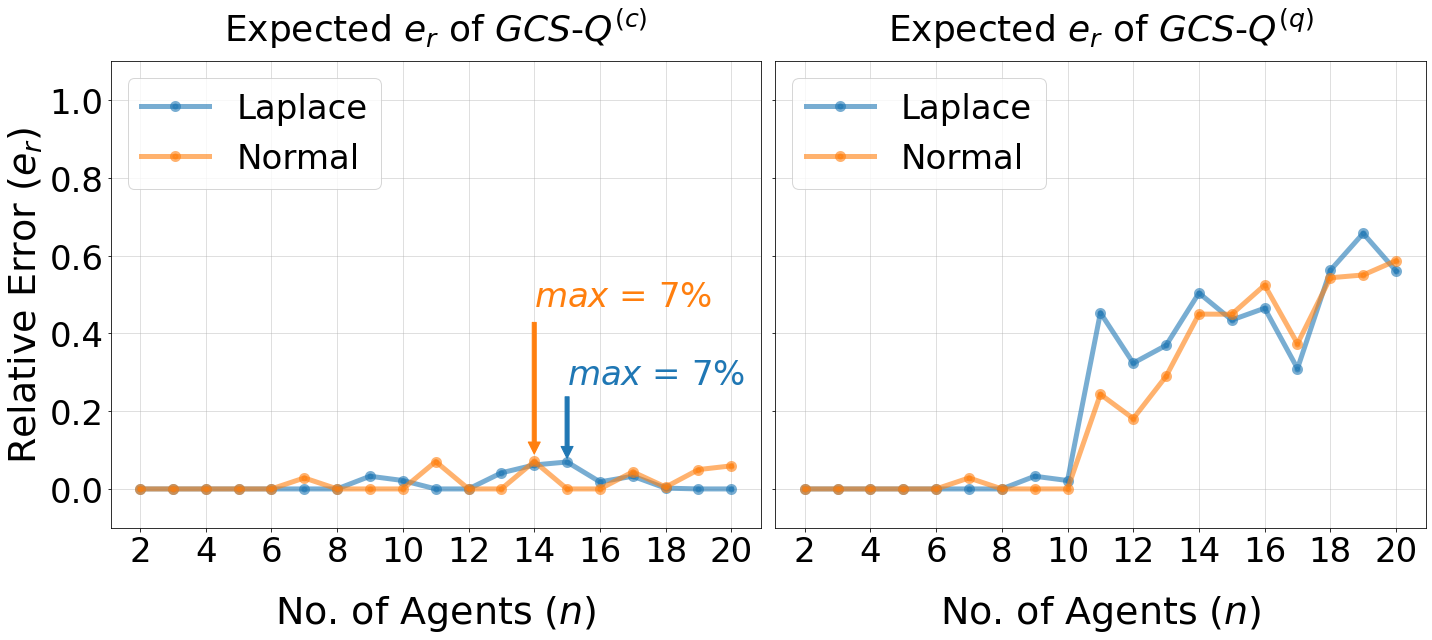

In [37]:
font=28

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(20,9))
fig.set_tight_layout(True)
ax[0].set_ylabel(r"Relative Error $(e_r)$", fontsize=font+10)

report_filename = "IDP_report_111_123.txt"
df = collect_files(report_filename)
df.head()

current_folder = file = os.path.join(folder, 'Quality')
create_dir(current_folder)

data = pd.concat([df["Distribution"] , df["No. of Agents"], df[('Top-down approach using min-cut', 'Quality')]], axis = 1)
data.columns = ["Distribution", "n", "Quality"]
data.Quality = data.Quality.astype(float)
data['Error'] = 1-data.Quality
data.head()

colors=['#1f77b4','#ff7f0e']
c = 0

for distr in df.Distribution.unique():
    if distr == "uniform":
        continue
    current_data = data[data.Distribution == distr]
    
    x = current_data['n'].to_numpy()

    y = current_data['Error'].astype(float).to_numpy()
    
    ax[0].plot(x, y, label=distr.capitalize(), linestyle='-', marker='o', linewidth=5.0, markeredgewidth=5, alpha=.6)

    ymax = max(y)
    xpos = np.where(y==ymax)
    xmax = x[xpos]

    ax[0].annotate("$max$ = "+f"{np.round(ymax*100).astype(int)}%", xy=(xmax, ymax), xytext=(xmax, ymax+0.4 if c else ymax+0.2), color= colors[c], fontsize=font+6,
                arrowprops=dict(color=colors[c], facecolor=colors[c], shrink=0.05))
    c+=1

ax[0].set_xlabel(r'No. of Agents $(n)$',fontdict={'fontsize':font+10}, labelpad=25)
ax[0].set_ylim(-.1, 1.1)

ax[0].set_xticks(ticks=np.arange(0, 20, 2))
ax[0].set_yticks(ticks=np.arange(0, 1.1, .2))

ax[0].tick_params(axis='both', which='major', labelsize=font+6)

ax[0].grid(alpha=.5)
ax[0].legend(fontsize=font+6, loc="upper left")

ax[0].set_title(r"Expected $e_r$ of $GCS$-$Q^{(c)}$", fontdict={'fontsize':font+8}, pad=20)#, fontweight="bold")


df = collect_files(report_filename)
df.head()

data = pd.concat([df["Distribution"] , df["No. of Agents"], df[('Dwave Annealer', 'Quality')]], axis = 1)
data.columns = ["Distribution", "n", "Quality"]
data.Quality = data.Quality.astype(float)
data['Error'] = 1-data.Quality
data.head()




c = 0

for distr in df.Distribution.unique():
    if distr == "uniform":
        continue
    current_data = data[data.Distribution == distr]
    
    x = current_data['n'].to_numpy()

    y = current_data['Error'].astype(float).to_numpy()
    
    ax[1].plot(x, y, label=distr.capitalize(), linestyle='-', marker='o', linewidth=5.0, markeredgewidth=5, alpha=.6)

    ymax = max(y)
    xpos = np.where(y==ymax)
    xmax = x[xpos]

    #ax[1].annotate("$max$ = "+f"{np.round(ymax*100).astype(int)}%", xy=(xmax, ymax), xytext=(xmax, ymax+0.4 if c else ymax+0.2), color= colors[c], fontsize=font+6,
     #           arrowprops=dict(color=colors[c], facecolor=colors[c], shrink=0.05))
    c+=1

ax[1].set_xlabel(r'No. of Agents $(n)$',fontdict={'fontsize':font+10}, labelpad=25)
ax[1].set_ylim(-.1, 1.1)

ax[1].set_xticks(ticks=np.arange(0, 20, 2))
ax[1].set_yticks(ticks=np.arange(0, 1.1, .2))

ax[1].tick_params(axis='both', which='major', labelsize=font+6)

ax[1].grid(alpha=.5)
ax[1].legend(fontsize=font+6, loc="upper left")

ax[1].set_title(r"Expected $e_r$ of $GCS$-$Q^{(q)}$", fontdict={'fontsize':font+8}, pad=20)#, fontweight="bold")

file = os.path.join(current_folder, 'GCS-Q_relative_errors.png')
plt.savefig(file, dpi=500, bbox_inches = "tight")
plt.show()

In [ ]:
data = pd.concat([df["Distribution"] , df["No. of Agents"], df[('Dwave Annealer', 'Quality')]], axis = 1)
data.columns = ["Distribution", "n", "Quality"]
data.Quality = data.Quality.astype(float)
data['Error'] = 1-data.Quality
data.head()

,Distribution,n,Quality,Error
0,laplace,2,1.0,0.0
1,laplace,3,1.0,0.0
2,laplace,4,1.0,0.0
3,laplace,5,1.0,0.0
4,laplace,6,1.0,0.0


In [ ]:
colors=['#1f77b4','#ff7f0e']
c = 0

for distr in df.Distribution.unique():
    if distr == "uniform":
        continue
    current_data = data[data.Distribution == distr]
    
    x = current_data['n'].to_numpy()

    y = current_data['Error'].astype(float).to_numpy()
    
    ax[1].plot(x, y, label=distr.capitalize(), linestyle='-', marker='o', linewidth=5.0, markeredgewidth=5, alpha=.6)

    ymax = max(y)
    xpos = np.where(y==ymax)
    xmax = x[xpos]

    ax[1].annotate("$max$ = "+f"{np.round(ymax*100).astype(int)}%", xy=(xmax, ymax), xytext=(xmax, ymax+0.4 if c else ymax+0.2), color= colors[c], fontsize=font+6,
                arrowprops=dict(color=colors[c], facecolor=colors[c], shrink=0.05))
    c+=1

ax[1].set_xlabel(r'No. of Agents $(n)$',fontdict={'fontsize':font+10}, labelpad=25)
ax[1].set_ylim(-.1, 1.1)

ax[1].set_xticks(ticks=np.arange(0, 20, 2))
ax[1].set_yticks(ticks=np.arange(0, 1.1, .2))

ax[1].tick_params(axis='both', which='major', labelsize=font+6)

ax[1].grid(alpha=.5)
ax[1].legend(fontsize=font+6, loc="upper left")

ax[1].set_title(r"Expected $e_r$ of $GCS$-$Q^{(q)}$", fontdict={'fontsize':font+8}, pad=20)#, fontweight="bold")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


Text(0.5, 1.0, 'Expected $e_r$ of $GCS$-$Q^{(q)}$')

## Plot the Qualit of $GCS-Q^{(c)}$ vs $GCS-Q^{(q)}$

In [ ]:
report_filename = "IDP_report_011_123.txt"
#report_filename = "IDP_report_111_123.txt"

IDP_brute_force = bool(int(report_filename.split('_')[-2][0]))
IDP_topdown_min_cut = bool(int(report_filename.split('_')[-2][1]))
IDP_min_cut_dwave_annealer = bool(int(report_filename.split('_')[-2][2]))

report_file_obj = open(os.path.join(report_filename),'r')
table_contents = [line.replace('\n','').split('__') for line in report_file_obj.readlines()]

In [ ]:
current_folder = file = os.path.join(folder, 'QA_runtime')
create_dir(current_folder)

In [ ]:
#view output table
def highlight_false(s, column):
    is_false = pd.Series(data=False, index=s.index)
    is_false[column] = round(s.loc[column],2)<1.0
    return ['color: #ff8888' if is_false.any() else '' for v in is_false]

base_cols = ['Distribution', 'No. of Agents']
sub_cols = ['', '']

if IDP_brute_force:
    base_cols = base_cols+['Brute Force']*3
    sub_cols=sub_cols+['Result', 'Value', 'TTE']
if IDP_topdown_min_cut:
    base_cols = base_cols+['Top-down approach using min-cut']*4
    sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']
if IDP_min_cut_dwave_annealer:
    base_cols = base_cols+['Dwave Annealer']*4
    sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']


column_arrays = [base_cols, sub_cols]

df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))
pd.set_option('display.max_rows', None)
df.head()

Distribution No. of Agents Top-down approach using min-cut  \
                                                      Result   
0      laplace             2                         ['1,2']   
1      laplace             3                    ['3', '1,2']   
2      laplace             4               ['2,4', '3', '1']   
3      laplace             5                ['1,2,5', '3,4']   
4      laplace             6              ['1,3,6', '2,4,5']   

                                                          Dwave Annealer  \
                Value                    TTE Quality              Result   
0                 2.5                    0.0       1             ['1,2']   
1                 2.5                    0.0       1        ['1,2', '3']   
2                2.89                    0.0       1   ['1', '3', '2,4']   
3  21.639999999999997                    0.0       1    ['1,2,5', '3,4']   
4  21.099999999999998  0.0010342597961425781       1  ['2,4,5', '1,3,6']   

                                                  
                Value                TTE Quality  
0                 2.5                0.0     1.0  
1                 2.5  5.190215110778809     1.0  
2                2.89  10.37340497970581     1.0  
3  21.639999999999997  9.827338695526123     1.0  
4  21.099999999999998  14.80012822151184     1.0

Approximation of (Classical) GCS-Q


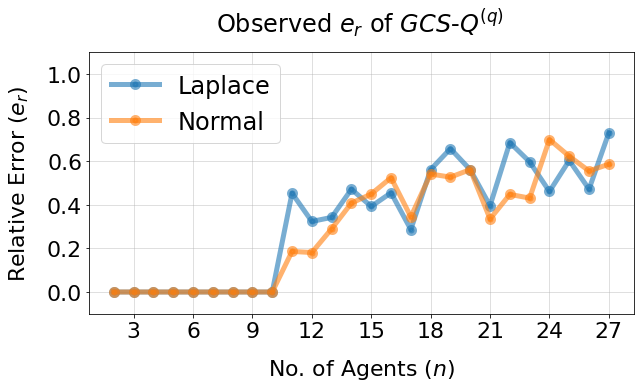

In [ ]:
data = pd.concat([df["Distribution"] , df["No. of Agents"], df[('Dwave Annealer', 'Quality')]], axis = 1)
data.columns = ["Distribution", "n", "Quality"]
data.Quality = data.Quality.astype(float)

data['Error'] = 1-data.Quality
font=16

fig, ax = plt.subplots(figsize=(9,5.5))
fig.set_tight_layout(True)

colors=['#1f77b4','#ff7f0e']
c = 0

for distr in df.Distribution.unique():
    if distr == "uniform":
        continue
    current_data = data[data.Distribution == distr]
    
    x = current_data['n'].to_numpy()

    y = current_data['Error'].astype(float).to_numpy()
    
    ax.plot(x, y, label=distr.capitalize(), linestyle='-', marker='o', linewidth=5.0, markeredgewidth=5, alpha=.6)

    ymax = max(y)
    xpos = np.where(y==ymax)
    xmax = x[xpos]
    c+=1


ax.set_ylabel(r'Relative Error $(e_r)$',fontdict={'fontsize':font+6}, labelpad=16)

ax.set_xlabel(r'No. of Agents $(n)$',fontdict={'fontsize':font+6}, labelpad=16)
ax.set_ylim(-.1, 1.1)

ax.set_xticks(ticks=np.arange(1, 28, 3))
ax.set_yticks(ticks=np.arange(0, 1.1, .2))

ax.tick_params(axis='both', which='major', labelsize=font+6)

ax.grid(alpha=.5)
ax.legend(fontsize=font+8, loc="upper left")

ax.set_title(r"Observed $e_r$ of $GCS$-$Q^{(q)}$ ", fontdict={'fontsize':font+8}, pad=20)

print("Approximation of (Classical) GCS-Q")

file = os.path.join(current_folder, 'QA_Acc_vs_Min-cut.png')
plt.savefig(file, dpi=300, bbox_inches = "tight")

### Plot Times to Execute for $IDP$, $GCS-Q^{(c)}$, $GCS-Q^{(q)}$

In [ ]:
report_filename = "IDP_report_111_123.txt"
df = collect_files(report_filename)
df.head()

Distribution No. of Agents         Brute Force                      \
                                          Result               Value   
0      laplace             2             ['1,2']                 2.5   
1      laplace             3        ['3', '1,2']                 2.5   
2      laplace             4   ['2,4', '3', '1']                2.89   
3      laplace             5    ['1,2,5', '3,4']  21.639999999999997   
4      laplace             6  ['1,3,6', '2,4,5']  21.099999999999998   

                         Top-down approach using min-cut                      \
                     TTE                          Result               Value   
0  0.0009906291961669922                         ['1,2']                 2.5   
1                    0.0                    ['3', '1,2']                 2.5   
2                    0.0               ['2,4', '3', '1']                2.89   
3  0.0009961128234863281                ['1,2,5', '3,4']  21.639999999999997   
4   0.001994609832763672              ['1,3,6', '2,4,5']  21.099999999999998   

                                      Dwave Annealer                      \
                     TTE Quality              Result               Value   
0                    0.0     1.0             ['1,2']                 2.5   
1  0.0010154247283935547     1.0        ['3', '1,2']                 2.5   
2  0.0009951591491699219     1.0   ['1', '3', '2,4']                2.89   
3                    0.0     1.0    ['1,2,5', '3,4']  21.639999999999997   
4  0.0009975433349609375     1.0  ['1,3,6', '2,4,5']  21.099999999999998   

                               
                  TTE Quality  
0                 0.0     1.0  
1   5.409874200820923     1.0  
2   9.935318231582642     1.0  
3   10.16195011138916     1.0  
4  14.997750997543335     1.0

In [ ]:
data = pd.concat([df["Distribution"] , df["No. of Agents"], df[('Brute Force', 'TTE')], 
                 df[('Top-down approach using min-cut', 'TTE')], df[('Dwave Annealer', 'TTE')]], axis = 1)
data.columns = ["Distribution", "n", "IDP", "GCS-Q Classical", "GCS-Q Quantum"]
data.head()

,Distribution,n,IDP,GCS-Q Classical,GCS-Q Quantum
0,laplace,2,0.0009906291961669922,0.0,0.0
1,laplace,3,0.0,0.0010154247283935547,5.409874200820923
2,laplace,4,0.0,0.0009951591491699219,9.935318231582642
3,laplace,5,0.0009961128234863281,0.0,10.16195011138916
4,laplace,6,0.001994609832763672,0.0009975433349609375,14.997750997543335


Plot together

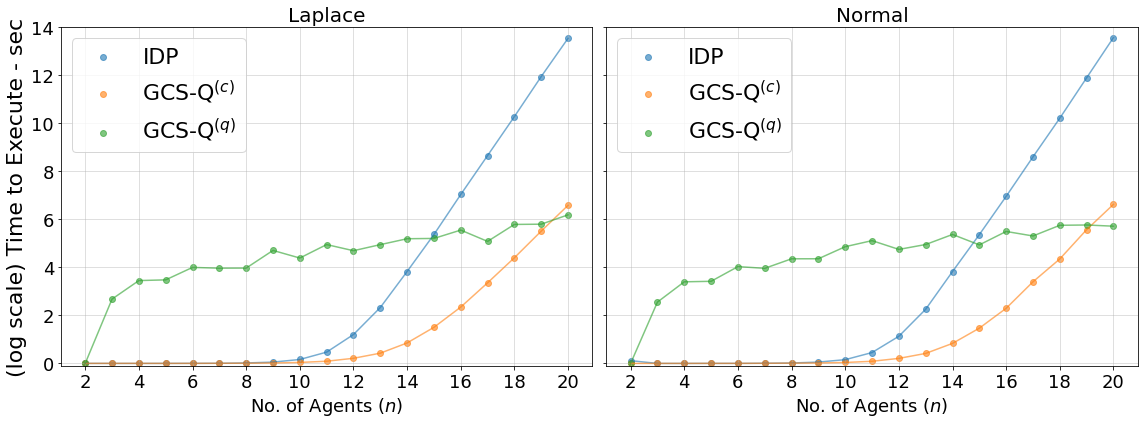

In [ ]:
font=14

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,6))
fig.set_tight_layout(True)
ax[0].set_ylabel(r"(log scale) Time to Execute - sec", fontsize=font+8)
ax[0].set_ylim(-.1, 1.1)
plt.setp(ax, xticks=np.arange(0, 20, 2), yticks = np.arange(0, 16, 2))

i=0

for distr in df.Distribution.unique():
    if distr == "uniform":
        continue
    current_data = data[data.Distribution == distr]
    x = current_data['n'].to_numpy()

    y_IDP = np.log2(current_data['IDP'].astype(float).to_numpy()+1)
    y_gcsq_c = np.log2(current_data['GCS-Q Classical'].astype(float).to_numpy()+1)
    y_gcsq_q = np.log2(current_data['GCS-Q Quantum'].astype(float).to_numpy()+1)

    ax[i].plot(x, y_IDP, alpha=.6)
    ax[i].scatter(x, y_IDP, label='IDP', alpha=.6)

    ax[i].plot(x, y_gcsq_c, alpha=.6)
    ax[i].scatter(x, y_gcsq_c, label='GCS-Q$^{(c)}$', alpha=.6)

    ax[i].plot(x, y_gcsq_q, alpha=.6)
    ax[i].scatter(x, y_gcsq_q, label='GCS-Q$^{(q)}$', alpha=.6)
    ax[i].set_xlabel(r'No. of Agents $(n)$',fontdict={'fontsize':font+4})
    ax[i].tick_params(axis="both", labelsize=font+4)
    ax[i].set_title(distr.title(), fontdict={'fontsize':font+6})
    ax[i].grid(alpha=.5)
    ax[i].legend(fontsize=font+8, loc="upper left")
    i+=1
file = os.path.join(current_folder, 'TTE_'+distr+'.png')
plt.savefig(file, dpi=500, bbox_inches = "tight")
plt.show()

### with Analytic Continuation

In [ ]:
def fit_function_idp(x, a1,a2,a3):
    local_variables = locals()
    co_effs = local_variables
    co_effs = list(co_effs.values())[1:][::-1]
    value = 0
    for i,coeff in enumerate(co_effs):
      value += coeff*np.power(x,i)
    return value


def fit_function_gcsq_classical(x, a1,a2,a3):
    local_variables = locals()
    co_effs = local_variables
    co_effs = list(co_effs.values())[1:][::-1]
    value = 0
    for i,coeff in enumerate(co_effs):
      value += coeff*np.power(x,i)
    return value

def fit_function_gcsq_quantum(x, a1,a2):
    local_variables = locals()
    co_effs = local_variables
    co_effs = list(co_effs.values())[1:][::-1]
    value = 0
    for i,coeff in enumerate(co_effs):
      value += coeff*np.power(x,i)
    return value

Times to Execute for laplace distribution
Times to Execute for normal distribution


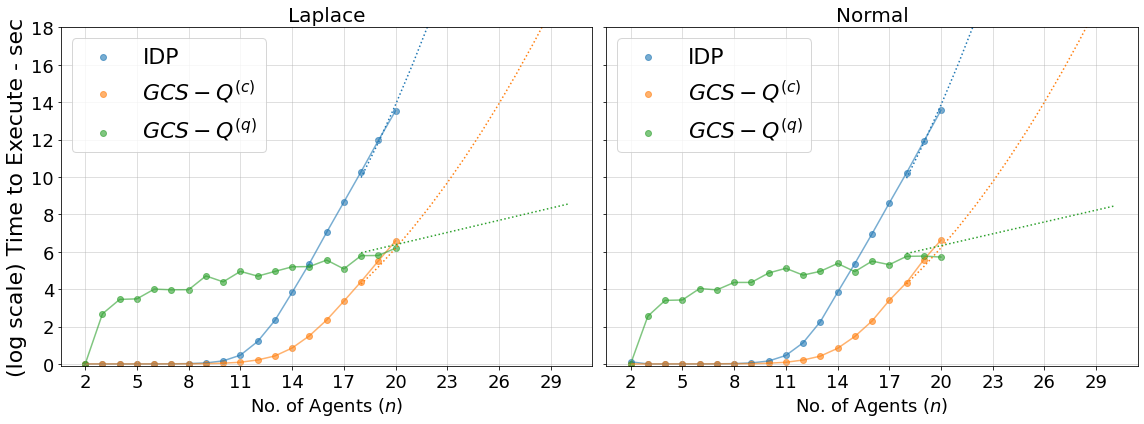

In [ ]:
font=14

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,6))
fig.set_tight_layout(True)
ax[0].set_ylabel(r"(log scale) Time to Execute - sec", fontsize=font+8)
ax[0].set_ylim(-.1, 1.1)
plt.setp(ax, xticks=np.arange(0, 30, 3), yticks = np.arange(0, 20, 2))

i=0

for distr in df.Distribution.unique():
    if distr == "uniform":
        continue
    current_data = data[data.Distribution == distr]

    #plt.figure(figsize=(8,5))
    x = current_data['n'].to_numpy()
    x_ints = np.array(list(map(int,x)))

    y_IDP = np.log2(current_data['IDP'].astype(float).to_numpy()+1)
    

    y_gcsq_c = np.log2(current_data['GCS-Q Classical'].astype(float).to_numpy()+1)
    

    y_gcsq_q = np.log2(current_data['GCS-Q Quantum'].astype(float).to_numpy()+1)
    

    ax[i].plot(x, y_IDP, alpha=.6)
    ax[i].scatter(x, y_IDP, label='IDP', alpha=.6)

    ax[i].plot(x, y_gcsq_c, alpha=.6)
    ax[i].scatter(x, y_gcsq_c, label='$GCS-Q^{(c)}$', alpha=.6)

    ax[i].plot(x, y_gcsq_q, alpha=.6)
    ax[i].scatter(x, y_gcsq_q, label='$GCS-Q^{(q)}$', alpha=.6)


    x_projection = np.arange(2,31)
    popt, pcov = curve_fit(fit_function_idp, x_ints, y_IDP)
    y_IDP_projection = fit_function_idp(x_projection, *popt)

    popt, pcov = curve_fit(fit_function_gcsq_classical, x_ints, y_gcsq_c)
    y_gcsq_c_projection = fit_function_gcsq_classical(x_projection, *popt)

    popt, pcov = curve_fit(fit_function_gcsq_quantum, x_ints, y_gcsq_q)
    y_gcsq_q_projection = fit_function_gcsq_quantum(x_projection, *popt)

    projection_start_index = 16

    ax[i].plot(np.array(list(map(str,np.arange(2,31))))[projection_start_index:],y_IDP_projection[projection_start_index:], linestyle = 'dotted', color = '#1f77b4')
    ax[i].plot(np.array(list(map(str,np.arange(2,31))))[projection_start_index:],y_gcsq_c_projection[projection_start_index:], linestyle = 'dotted', color = '#ff7f0e')
    ax[i].plot(np.array(list(map(str,np.arange(2,31))))[projection_start_index:],y_gcsq_q_projection[projection_start_index:], linestyle = 'dotted', color = '#2ca02c')
    ax[i].set_xlabel(r'No. of Agents $(n)$',fontdict={'fontsize':font+4})
    ax[i].set_title(distr.title(), fontdict={'fontsize':font+6})
    ax[i].tick_params(axis="both", labelsize=font+4)
    ax[i].grid(alpha=.5)
    ax[i].legend(fontsize=font+8, loc="upper left")
    print("Times to Execute for",distr,"distribution")
    i+=1
file = os.path.join(current_folder, 'TTE_'+distr+'.png')
plt.savefig(file, dpi=500, bbox_inches = "tight")
plt.show()

##QA performance for optimal split problem

To show the order of growth of time to execute as linear to that of the problem size

In [38]:
import os
import pandas as pd
import json
import matplotlib.pyplot as plt
from IPython.display import display, Math
from sklearn import linear_model
import sklearn as skl
import numpy as np

In [51]:
seed = 123
root='QA_results'
path = os.path.join(os.getcwd(), root, str(seed))
print(path)

/content/QA_results/123


In [52]:
name_cols =["distribution", "n", "run", 
            "qpu_sampling_time", "qpu_anneal_time_per_sample", 
            "qpu_readout_time_per_sample", "qpu_access_overhead_time", 
            "qpu_programming_time", "qpu_delay_time_per_sample", 
            "post_processing_overhead_time", "total_post_processing_time" ]

full_df = pd.DataFrame(columns= name_cols)

In [53]:
for root, dirs, files in os.walk(path):
    for name in files:
        if name.endswith(".json"):
            n, r = name, os.path.join(root)
            path_file=os.path.join(r, n)
            with open(path_file, 'r') as fh:
                result_dict = json.load(fh)
            
            row = [r.split("/")[-3], 
                   r.split("/")[-2], 
                   r.split("/")[-1],
                   result_dict['timing']['qpu_sampling_time'],
                   result_dict['timing']['qpu_anneal_time_per_sample'],
                   result_dict['timing']['qpu_readout_time_per_sample'],
                   result_dict['timing']['qpu_access_overhead_time'],
                   result_dict['timing']['qpu_programming_time'],
                   result_dict['timing']['qpu_delay_time_per_sample'],
                   result_dict['timing']['post_processing_overhead_time'],
                   result_dict['timing']['total_post_processing_time']
                  ]
            row = pd.Series(row, index=name_cols)
            full_df = full_df.append(row, ignore_index=True)

In [54]:
r

'/content/QA_results/123/normal/48/run_4'

In [55]:
pd.set_option('display.max_rows', 500)

full_df['total'] = full_df['qpu_sampling_time'] + full_df['qpu_access_overhead_time'] + full_df['qpu_programming_time'] + full_df['post_processing_overhead_time']
full_df.head()

,distribution,n,run,qpu_sampling_time,qpu_anneal_time_per_sample,qpu_readout_time_per_sample,qpu_access_overhead_time,qpu_programming_time,qpu_delay_time_per_sample,post_processing_overhead_time,total_post_processing_time,total
0,uniform,45,run_2,955760.0,20.0,198.4,17109.70,11199.30,20.54,1520.0,7841.0,985589.0
1,uniform,45,run_1,955760.0,20.0,198.4,23059.30,11215.70,20.54,823.0,7897.0,990858.0
2,uniform,45,run_5,955760.0,20.0,198.4,16257.70,11204.30,20.54,2052.0,8223.0,985274.0
3,uniform,45,run_3,955760.0,20.0,198.4,21433.89,11139.11,20.54,1478.0,12633.0,989811.0
4,uniform,45,run_4,955760.0,20.0,198.4,23245.90,11253.10,20.54,1424.0,8831.0,991683.0


In [56]:
def plot_and_save(full_df, column, seed, path, rescaling = 10**6, font=16, figsize=(7,5)):
    mean = full_df.groupby(['distribution', 'n']).mean()[[column]]
    mean.columns += '_mean'

    std = full_df.groupby(['distribution', 'n']).std()[[column]]
    std.columns += '_std'

    maximum = full_df.groupby(['distribution', 'n']).max()[[column]]
    maximum.columns += '_max'

    minimum = full_df.groupby(['distribution', 'n']).min()[[column]]
    minimum.columns += '_min'
    
    df = mean.join(std)
    df = df.join(maximum)
    df = df.join(minimum)
    
    df = df/rescaling
    df = df.reset_index()
    
    df["upper"] = df[column + '_mean'] + df[column + '_std']
    df["lower"] = df[column + '_mean'] - df[column + '_std']
    
    for distr in df.distribution.unique():
        data = df.loc[df.distribution == distr, ]
        data['n'] = data['n'].astype(int)
        data = data.sort_values(by="n")
        
        fig, ax = plt.subplots(figsize=figsize)
        fig.set_tight_layout(True)
        # plt.figure(figsize=(10,6))

        ax.plot(data['n'], data[column + '_mean'])  
        ax.scatter(data['n'], data[column + '_mean'])

        ax.fill_between(data['n'], data["lower"], data["upper"], color = 'turquoise',alpha = 0.6, edgecolor="b", label=r"$\mu \pm \sigma$")
        ax.fill_between(data['n'], data[column + "_min"], data[column + "_max"], color = 'orange',alpha = 0.2, edgecolor="b", label="MIN-MAX")
        ax.plot(data['n'], data[column + '_max'], color = 'orange')
        ax.plot(data['n'], data[column + '_min'], color = 'orange')
        
        ax.set_ylabel(r"D-Wave 2000Q runtime ($\mu s$)", fontsize=font-2)
        ax.set_xlabel("n. of agents", fontsize=font-2)
        
        ax.tick_params(axis='both', which='major', labelsize=font-4)
        
        ax.set_title(distr.capitalize(), fontsize=font)
        ax.grid(alpha=.5)
        ax.legend(fontsize=font-4, loc="upper left")
        
        variable_path = os.path.join(path, column)
        create_dir(variable_path)
        file = os.path.join(variable_path, distr +".jpeg")
        print(file)
        
        
        ## Linear Regression
        x = data['n'].astype(float).to_numpy()
        y = data[column + '_mean'].astype(float).to_numpy()
        
        length = len(x)
        print(length)

        x = x.reshape(length, 1)
        y = y.reshape(length, 1)
        
        regr = linear_model.LinearRegression()
        model = regr.fit(x,y)

        b1 = regr.coef_[0][0]
        b0 = regr.intercept_[0]
        regr.intercept_
        print("b0 = ",regr.intercept_)
        print("b1 = ",regr.coef_[0][0])
        
        textstr = '\n'.join((r'$\beta_0=%.2f \times 10^6$' % (b0/10**6, ),
                             r'$\beta_1=%.2f  \times 10^3$' % (b1/10**3, ),
                             r'$R^2=%.1f$' % (skl.metrics.r2_score(y, regr.predict(x))*100, ) + '%'))
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.6)

        # place a text box in upper left in axes coords
        ax.text(0.70, 0.06, textstr, transform=ax.transAxes, fontsize=font-6,
                verticalalignment='bottom', bbox=props)

        plt.savefig(file, dpi=300)
        print("file",file)
        plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


64
b0 =  [965031.8872207]
b1 =  566.6285531135533
64
b0 =  [964797.18457875]
b1 =  573.1335760073259
file /content/QA_results/123/output/total/opt_split_65_QA.jpeg


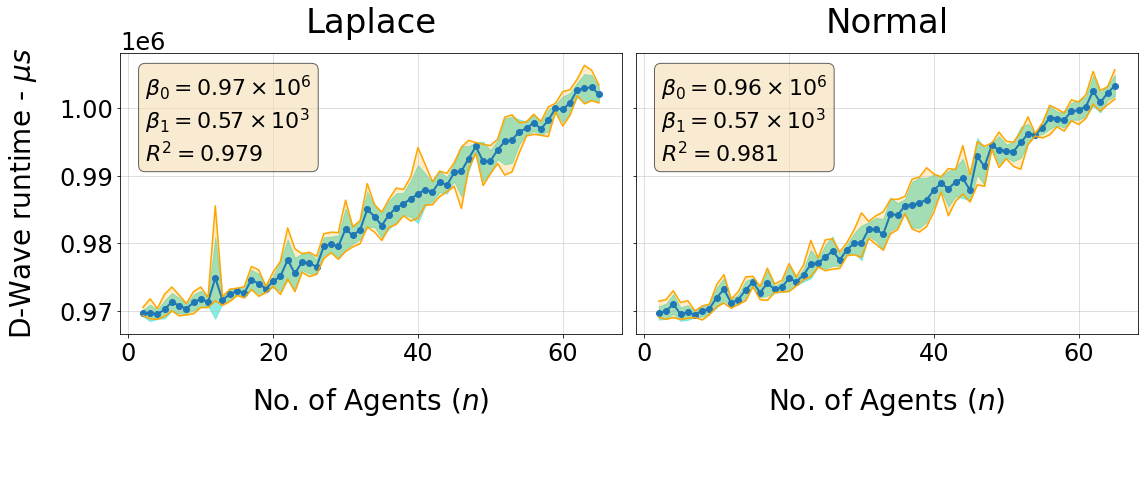

In [57]:

column= "total"
path = os.path.join(path, "output")
rescaling = 1
font=20


mean = full_df.groupby(['distribution', 'n']).mean()[[column]]
mean.columns += '_mean'

std = full_df.groupby(['distribution', 'n']).std()[[column]]
std.columns += '_std'

maximum = full_df.groupby(['distribution', 'n']).max()[[column]]
maximum.columns += '_max'

minimum = full_df.groupby(['distribution', 'n']).min()[[column]]
minimum.columns += '_min'
    
df = mean.join(std)
df = df.join(maximum)
df = df.join(minimum)
    
df = df/rescaling
df = df.reset_index()
    
df["upper"] = df[column + '_mean'] + df[column + '_std']
df["lower"] = df[column + '_mean'] - df[column + '_std']



fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
fig.set_tight_layout(True)
ax[0].set_ylabel(r"D-Wave runtime - $\mu s$", fontsize=font+8, labelpad=20)
ax[0].yaxis.get_offset_text().set_fontsize(font+4)
i=0

for distr in df.distribution.unique():
    if distr == "uniform":
        continue
    data = df.loc[df.distribution == distr, ]
    data['n'] = data['n'].astype(int)
    data = data.sort_values(by="n")
    
    # plt.figure(figsize=(10,6))

    ax[i].plot(data['n'], data[column + '_mean'],linestyle='-', marker='o', linewidth=2.0, markeredgewidth=1)  
    #ax[i].scatter(data['n'], data[column + '_mean'])

    ax[i].fill_between(data['n'], data["lower"], data["upper"], color = 'turquoise',alpha = 0.6, edgecolor="b", label=r"$\mu \pm \sigma$")
    ax[i].fill_between(data['n'], data[column + "_min"], data[column + "_max"], color = 'orange',alpha = 0.2, edgecolor="b", label="MIN-MAX")
    ax[i].plot(data['n'], data[column + '_max'], color = 'orange')
    ax[i].plot(data['n'], data[column + '_min'], color = 'orange')
    ax[i].set_xlabel("No. of Agents $(n)$", fontsize=font+8, labelpad=20)
    
    ax[i].tick_params(axis='both', which='major', labelsize=font+4)
    
    ax[i].set_title(distr.capitalize(), fontsize=font+14, pad=20) # + " - "  + column)
    ax[i].grid(alpha=.5)
    #ax[i].legend(fontsize=font-4, loc="upper left")
    
    variable_path = os.path.join(path, column)
    create_dir(variable_path)
    
    
    ## Linear Regression
    x = data['n'].astype(float).to_numpy()
    y = data[column + '_mean'].astype(float).to_numpy()
    
    length = len(x)
    print(length)

    x = x.reshape(length, 1)
    y = y.reshape(length, 1)
    
    regr = linear_model.LinearRegression()
    model = regr.fit(x,y)

    b1 = regr.coef_[0][0]
    b0 = regr.intercept_[0]
    regr.intercept_
    print("b0 = ",regr.intercept_)
    print("b1 = ",regr.coef_[0][0])
    
    textstr = '\n'.join((r'$\beta_0=%.2f \times 10^6$' % (b0/10**6, ),
                         r'$\beta_1=%.2f  \times 10^3$' % (b1/10**3, ),
                         r'$R^2=%.3f$' % (skl.metrics.r2_score(y, regr.predict(x)), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.6)

    # place a text box in upper left in axes coords
    ax[i].text(0.05, 0.6, textstr, transform=ax[i].transAxes, fontsize=font+2,
            verticalalignment='bottom', bbox=props)
    i+=1
    
#ax[i].legend(fontsize=font+4, loc="upper right")
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize=font+8, ncol=4, bbox_to_anchor=(.72, .01))

file = os.path.join(variable_path, "opt_split_65_QA.jpeg")

plt.savefig(file, dpi=300, bbox_inches = "tight")
print("file", file)
plt.show()